In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

from machine_learning.autoencoders.feedforward_autoencoder import FeedforwardAutoencoder, FeedforwardCoderConfigs, init_decoder, init_encoder
from machine_learning.classes import OptimizerConfigs, TrainConfigs
from machine_learning.strings import l1_loss_str
from machine_learning.utils.utils_ecg import load_ecg_data_for_autoencoder
from machine_learning.utils.utils_nn import init_loss, train

In [2]:
sns.set_style("whitegrid")

figsize = (12, 8)

In [3]:
filepath = "../data/ecg.csv"
normal_X_train_loader, normal_X_val_loader, normal_X_test_loader, anomalous_X_loader = load_ecg_data_for_autoencoder(filepath, True, drop_last=True)

### normal x and anomalous x

In [4]:
normal_X_test = normal_X_test_loader.dataset.X

In [5]:
anomalous_X_test = anomalous_X_loader.dataset.X

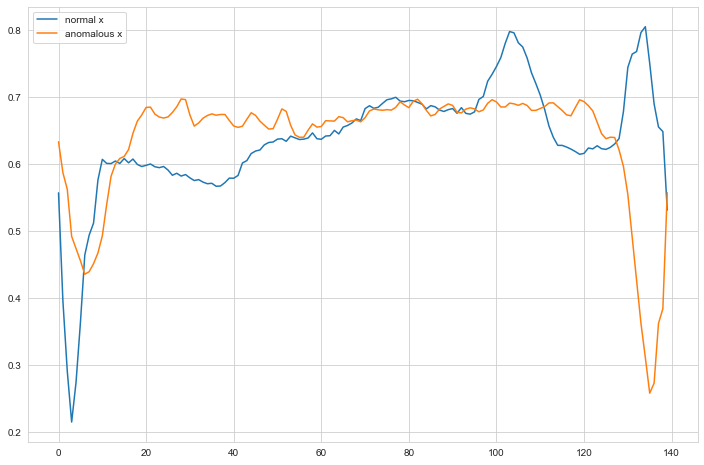

In [32]:
normal_x = normal_X_test[0]
anomalous_x = anomalous_X_test[0]

plt.figure(figsize=figsize)
plt.plot(normal_x, label='normal x')
plt.plot(anomalous_x, label='anomalous x')
plt.legend()
plt.show()

### model

In [7]:
x_dim = len(normal_x)
z_dim = 8
h_dims = [32, 16]

coder_configs = FeedforwardCoderConfigs(x_dim=x_dim, z_dim=z_dim, h_dims=h_dims)
encoder = init_encoder(x_dim, z_dim, h_dims)
decoder = init_decoder(x_dim, z_dim, h_dims)

model = FeedforwardAutoencoder(coder_configs, encoder, coder_configs, decoder)

In [8]:
optimizer_configs = OptimizerConfigs()

In [9]:
n_epochs = 20
patience = 20
configs = TrainConfigs(optimizer_configs=optimizer_configs, n_epochs=n_epochs, patience=patience)

In [10]:
criterion = init_loss(l1_loss_str)

In [11]:
verbose = True
verbose_freq = n_epochs / 10

In [12]:
best_state_dict, best_val_loss, best_epoch = train(configs, model, normal_X_train_loader, normal_X_val_loader, 
                                                   criterion, verbose, verbose_freq)

epoch 0, train loss 0.0023050203941227926, val loss 0.0022190235812088537
epoch 2, train loss 0.001116785592149094, val loss 0.0008264300445544309
epoch 4, train loss 0.0005074163263399116, val loss 0.003996163092810532
epoch 6, train loss 0.0004238234582893903, val loss 0.0005091520219013608
epoch 8, train loss 0.00035471405621241683, val loss 0.0005229735554292285
epoch 10, train loss 0.0003172075825894734, val loss 0.00036463574988060984
epoch 12, train loss 0.00030719621944218044, val loss 0.0007331438812202421
epoch 14, train loss 0.0002925555085833332, val loss 0.00036314943933795236
epoch 16, train loss 0.000272856656191057, val loss 0.0003196434374770214
epoch 18, train loss 0.0002542074166125586, val loss 0.0002968901704097616


### reconstructing normal xs

In [13]:
encoder = init_encoder(**coder_configs.dict())
decoder = init_decoder(**coder_configs.dict())
best_model = FeedforwardAutoencoder(coder_configs, encoder, coder_configs, decoder)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [18]:
test_size = len(normal_X_test)

In [14]:
best_model.eval()
normal_X_test_hat = best_model(normal_X_test)
normal_X_test_hat = normal_X_test_hat.detach()

normal_test_loss = tf.keras.losses.mae(normal_X_test_hat, normal_X_test)
normal_test_loss = normal_test_loss.eval(session=tf.compat.v1.Session())

2022-06-10 18:22:33.484529: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
np.mean(normal_test_loss), np.std(normal_test_loss)

(0.016472705, 0.008122078)

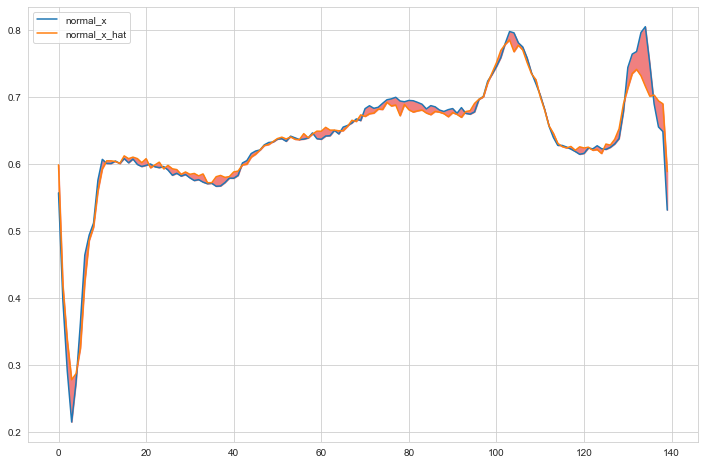

In [16]:
normal_x_test = normal_X_test[0]
normal_x_test_hat = normal_X_test_hat[0]
plt.figure(figsize=figsize)
plt.plot(normal_x_test, label='normal_x')
plt.plot(normal_x_test_hat, label='normal_x_hat')
plt.fill_between(np.arange(len(normal_x_test)), normal_x_test_hat, normal_x_test, color='lightcoral')
plt.legend()
plt.show()

### reconstructing anomalous xs

In [19]:
anomalous_X_test = anomalous_X_test[:test_size]
anomalous_X_test_hat = best_model(anomalous_X_test)
anomalous_X_test_hat = anomalous_X_test_hat.detach()

anomalous_test_loss = tf.keras.losses.mae(anomalous_X_test_hat, anomalous_X_test)
anomalous_test_loss = anomalous_test_loss.eval(session=tf.compat.v1.Session())

In [20]:
np.mean(anomalous_test_loss), np.std(anomalous_test_loss)

(0.049451675, 0.009766531)

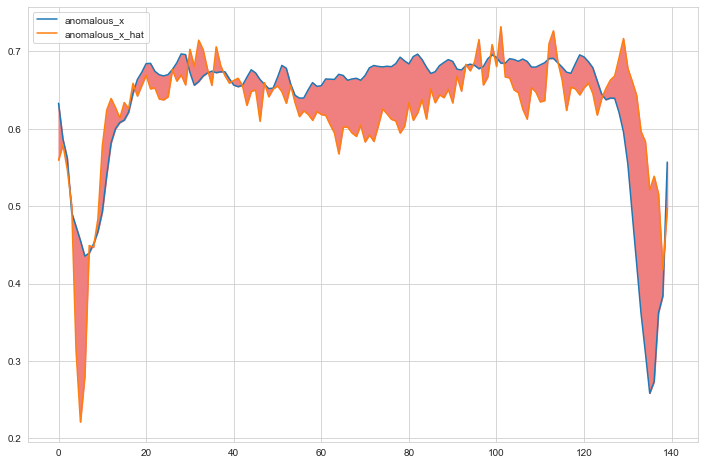

In [21]:
anomalous_x_test = anomalous_X_test[0]
anomalous_x_test_hat = anomalous_X_test_hat[0]
plt.figure(figsize=figsize)
plt.plot(anomalous_x_test, label='anomalous_x')
plt.plot(anomalous_x_test_hat, label='anomalous_x_hat')
plt.fill_between(np.arange(len(anomalous_x_test)), anomalous_x_test_hat, anomalous_x_test, color='lightcoral')
plt.legend()
plt.show()

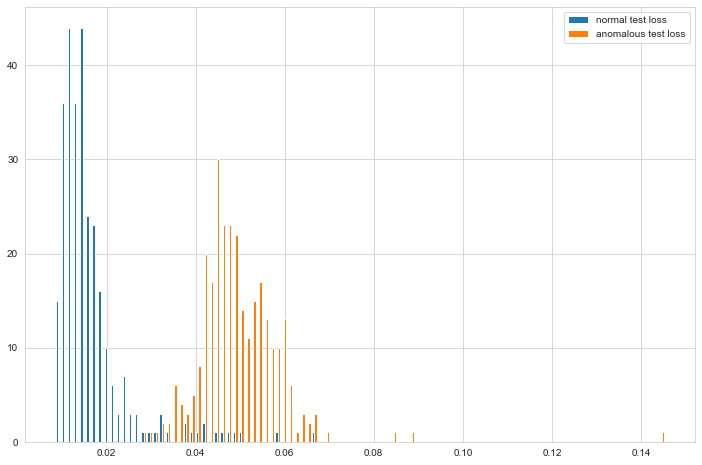

In [22]:
plt.figure(figsize=figsize)
plt.hist([normal_test_loss, anomalous_test_loss], bins=100, label=['normal test loss', 'anomalous test loss'])
plt.legend(loc='upper right')
plt.show()

### predicting samples

In [23]:
normal_X_val = normal_X_val_loader.dataset.X

In [24]:
normal_X_val_hat = best_model(normal_X_val)
normal_X_val_hat = normal_X_val_hat.detach()

In [25]:
normal_val_loss = tf.keras.losses.mae(normal_X_val, normal_X_val_hat)
normal_val_loss = normal_val_loss.eval(session=tf.compat.v1.Session())

In [35]:
# x with loss below this to be considered normal, x with loss above this to be considered anomalous
threshold = np.mean(normal_val_loss) + np.std(normal_val_loss)
threshold

0.02464782

In [27]:
# in this dataset, normal xs are labeled 1
normal_Y_test = np.ones(len(normal_X_test))
anomalous_Y_test = np.zeros(len(anomalous_X_test))
Y_test = np.hstack([normal_Y_test, anomalous_Y_test])

In [28]:
normal_Y_test_pred = normal_test_loss <= threshold
anomalous_Y_test_pred = anomalous_test_loss <= threshold
Y_test_pred = np.hstack([normal_Y_test_pred, anomalous_Y_test_pred])

In [29]:
accuracy_score(Y_test, Y_test_pred)

0.9534482758620689

In [30]:
precision_score(Y_test, Y_test_pred)

1.0

In [31]:
recall_score(Y_test, Y_test_pred)

0.906896551724138